In [ ]:
#|default_exp basiccolor

# Comparison with BasICColor 

It is now interesting to compare the output of our computations with the report produced by [BasICColor Input6 Pro](https://www.basiccolor.de/products/). 

In [ ]:
from colorchecker2cielab import extract_color_patches, read_target_data, read_basiccolor_data, RGBs_to_LABs, compute_deltaEs
import pandas as pd

In [ ]:
target_data = '/home/frank/Work/DATA/colorchecker2cielab-data/AG_003_20221230_2.txt' 
bcol_data = '/home/frank/Work/DATA/colorchecker2cielab-data/BasiCColor_sk-c-1833.xlsx'
tif_file = '/home/frank/Work/DATA/colorchecker2cielab-data/sk-C-1833_135MB.tif' 

In [ ]:
bcol_df = read_basiccolor_data(bcol_data)
bcol_LABs = bcol_df.loc[:, ['bcol_L*', 'bcol_a*', 'bcol_b*']]
print('BasICColor report: \n')
print(bcol_df.to_string())

BasICColor report: 

     bcol_R  bcol_G  bcol_B  ref_L*  ref_a*  ref_b*  bcol_L*  bcol_a*  bcol_b*  bcol_ΔE*00_(SL=1)  bcol_Δab*
A1    95.58   95.78   94.15   95.35   -0.75    2.56    95.59    -0.27     2.76               0.77       0.73
B1    49.25   49.46   49.12   49.51   -0.53    0.38    49.37     0.09     0.88               1.05       1.04
C1     7.83    7.53    7.47    8.59    0.26   -0.70     7.62     0.94     0.75               1.97       1.72
D1    95.86   96.18   94.72   95.62   -0.80    2.35    95.97    -0.40     2.45               0.68       0.59
E1    49.26   49.50   49.12   49.53   -0.54    0.41    49.39     0.04     0.91               1.00       0.99
F1     7.51    7.22    7.19    8.47    0.16   -0.86     7.31     0.95     0.71               2.24       1.91
G1    95.74   96.09   94.66   95.50   -0.82    2.40    95.87    -0.43     2.39               0.67       0.56
H1    49.25   49.48   49.16   49.53   -0.54    0.44    49.38     0.06     0.84               0.98       0.9

In the table above we see on the left the `bcol_RGB` columns. These are the RGB values that were extracted from the TIF image of the target by BasICColor. Next we find the `ref_L*a*b*` columns. These are the measured CIELAB values that are tabulated for this specific Colorchecker target. Next we see the `bcol_L*a*b*` values that are computed by BasICColor from the extracted RGB values for all color patches. Finally on the right we find two deltaE columns that indicate the color differences between the reference CIELAB values and the computed CIELAB values. The `bcol_ΔE*00_(SL=1)` indicates the deltaE CIE2000 color difference that has been adapted by setting `SL` to 1. Not sure yet how this choice has been motivated. The last column most probably indicates the CIE1976 deltaE color difference.  

Now let's create a similar report table using the colorchecker2cielab functions. 

In [ ]:
rectangles, RGBs = extract_color_patches(tif_file, make_plot=False) 
ref_LABs = read_target_data(target_data) 
LABs = RGBs_to_LABs(RGBs)
deltas = compute_deltaEs(ref_LABs, LABs)

In [ ]:
report = pd.concat([RGBs*100, deltas], axis=1)

In [ ]:
print('Colorchecker2cielab report: \n')
print(report.to_string())

Colorchecker2cielab report: 

        R     G     B  ref_L*  ref_a*  ref_b*    L*     a*     b*  dE_2000  dE_1976
A1  95.54 95.76 94.14   95.35   -0.75    2.56 95.56  -0.76   2.22     0.33     0.40
B1  49.27 49.46 49.14   49.51   -0.53    0.38 49.37  -0.39   0.36     0.24     0.20
C1   7.92  7.64  7.57    8.59    0.26   -0.70  7.72   0.42   0.26     1.11     1.30
D1  95.85 96.18 94.72   95.62   -0.80    2.35 95.96  -0.89   1.92     0.46     0.55
E1  49.25 49.45 49.12   49.53   -0.54    0.41 49.36  -0.41   0.37     0.26     0.22
F1   7.62  7.31  7.26    8.47    0.16   -0.86  7.41   0.45   0.24     1.34     1.56
G1  95.71 96.07 94.64   95.50   -0.82    2.40 95.85  -0.95   1.88     0.56     0.64
H1  49.24 49.47 49.15   49.53   -0.54    0.44 49.37  -0.44   0.34     0.24     0.22
I1   7.48  7.34  7.21    8.44    0.27   -0.82  7.38   0.17   0.26     1.26     1.52
J1  95.78 96.13 94.73   95.63   -0.81    2.34 95.91  -0.92   1.84     0.52     0.59
K1  49.25 49.48 49.20   49.46   -0.55    0.34 

In [ ]:
#|hide 
# report.to_excel('colorchecker2cielab-report-voor-Henni.xlsx')

By comparing both results, what do we learn? These are lot's of numbers to compare, so let's try to break this down. 

The most dramatic difference between reports is the large difference in the CIE2000 deltaE. Let's create a plot to make that clear...

In [ ]:
bcol_deltaE_2000_SL_1 = bcol_df.loc[:, 'bcol_ΔE*00_(SL=1)'].values 
cc2c_deltaE_2000 = report.loc[:, 'dE_2000'].values 

In [ ]:
import matplotlib.pyplot as plt 

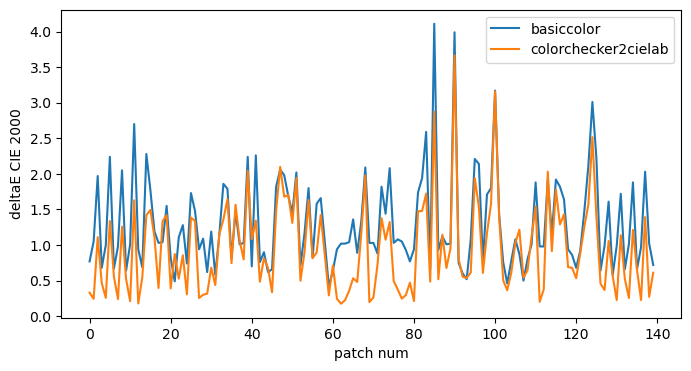

In [ ]:
fig, ax = plt.subplots(figsize=[8, 4])
ax.plot(range(len(names)), bcol_deltaE_2000_SL_1, label='basiccolor')
ax.plot(range(len(names)), cc2c_deltaE_2000, label='colorchecker2cielab')
ax.set_ylabel('deltaE CIE 2000')
ax.set_xlabel('patch num')
ax.legend();

In [ ]:
#|export 

import pandas as pd 
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt

In [ ]:
#|export 

def read_basiccolor_data(basiccolor_excel):
    '''Ad hoc code to parse from BasICColor excel report (based on html output) and
    return color values as dataframe. '''
    
    # select full rectangle with values 
    basicc_df = pd.read_excel(basiccolor_excel, skiprows=18, header=0, nrows=141, usecols='D:U')
    basicc_df = basicc_df.drop(index=0)
    basicc_df.set_index('Name', inplace=True)
    basicc_df.index.name = None
    
    # select standard columns and drop some delta columns 
    basicc_sel_df = basicc_df.loc[:, ['R %', 'G %', 'B %', 'L*', 'a*', 'b*', 'L*.1', 'a*.1', 'b*.1', 'ΔE*00 (SL=1)', 'Δab*']] 
    
    # rename and create hierarchical column names 
    basicc_sel_df.columns = ['bcol_R', 'bcol_G', 'bcol_B', 'ref_L*', 'ref_a*', 'ref_b*', 'bcol_L*', 
                             'bcol_a*', 'bcol_b*', 'bcol_ΔE*00_(SL=1)', 'bcol_Δab*']
    
    return basicc_sel_df 